## Tesla Classification Model

Stock Movement Prediction Using Machine Learning

In [1]:
# Import libraries and packages
import numpy as np
import pandas as pd
from datetime import datetime 
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.tseries.offsets import BDay  # Business day offset
from scipy.stats import zscore
import yfinance as yf
from fredapi import Fred
# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

import ta

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from sklearn.model_selection import PredefinedSplit
import pickle
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier


Importing Datasets

In [2]:
# Importing features from Yahoo Finance
features = ['TSLA', # Tesla Stock Price
            '^VIX', # Volatility Index
            '^GSPC', # S&P 500 Index
            '^DJI', # Nasdaq Composite Index
            'BTC-USD', # Bitcoin Price
            '^TNX',  # 10-Year Treasury Yield
            'CL=F',  # Crude Oil Futures
            'BZ=F',  # Brent Oil Futures
            '^DJI',  # Dow Jones Industrial Average
            ]

# Getting Tesla Stock Price & Features from Yahoo Finance
yahoo_data = yf.download(features, start='2010-06-29', end='2025-03-18')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed


In [4]:
# Importing features from FRED
FRED_API_KEY = "94c4c85e75d751a806c45444ead0f393" 
fred = Fred(api_key=FRED_API_KEY)

# Define Economic Indicators
fred_series = {
    "CPI": "CPIAUCSL",  # Consumer Price Index
    "PPI": "PPIACO",  # Producer Price Index
    "Unemployment_Rate": "UNRATE",
    "Consumer_Sentiment": "UMCSENT",
    "Federal_Funds_Rate": "FEDFUNDS",
    "Durable_Goods_Orders": "DGORDER", 
    "Industrial_Production_Index": "INDPRO", 
    "Labor_Force_Participation": "CIVPART", 
    "Job_Openings_JOLTS": "JTSJOL", 
}

start_date = "2010-06-29"
end_date = datetime.today().strftime('%Y-%m-%d')

# Fetch Data from FRED
df_list = []
for feature, series in fred_series.items():
    data = fred.get_series(series, start_date, end_date)
    df = pd.DataFrame(data, columns=[feature])
    df.index = pd.to_datetime(df.index) 
    df_list.append(df)

# Merge All Data into a Single DataFrame
economic_data = pd.concat(df_list, axis=1)

In [5]:
yahoo_data.tail()

Price              Close                                                  \
Ticker           BTC-USD       BZ=F       CL=F        TSLA          ^DJI   
Date                                                                       
2025-03-13  81066.703125  69.879997  66.550003  240.679993  40813.570312   
2025-03-14  83969.101562  70.580002  67.180000  249.979996  41488.191406   
2025-03-15  84343.109375        NaN        NaN         NaN           NaN   
2025-03-16  82579.687500        NaN        NaN         NaN           NaN   
2025-03-17  84075.687500  71.070000  67.580002  238.009995  41841.628906   

Price                                          High                        \
Ticker            ^GSPC   ^TNX   ^VIX       BTC-USD       BZ=F       CL=F   
Date                                                                        
2025-03-13  5521.520020  4.274  24.66  84301.695312  71.239998  67.940002   
2025-03-14  5638.939941  4.308  21.77  85263.289062  70.750000  67.480003   
2025-03-15          NaN    NaN    NaN  84672.671875        NaN        NaN   
2025-03-16          NaN    NaN    NaN  85051.601562        NaN        NaN   
2025-03-17  5675.120117  4.306  20.51  84725.328125  71.790001  68.370003   

Price                                                                \
Ticker            TSLA          ^DJI        ^GSPC   ^TNX       ^VIX   
Date                                                                  
2025-03-13  248.289993  41360.121094  5597.779785  4.353  26.129999   
2025-03-14  251.580002  41528.109375  5645.270020  4.324  24.360001   
2025-03-15         NaN           NaN          NaN    NaN        NaN   
2025-03-16         NaN           NaN          NaN    NaN        NaN   
2025-03-17  245.399994  42013.101562  5703.520020  4.331  22.950001   

Price                Low                                                  \
Ticker           BTC-USD       BZ=F       CL=F        TSLA          ^DJI   
Date                                                                       
2025-03-13  79931.851562  69.680000  66.370003  232.600006  40661.769531   
2025-03-14  80797.562500  69.940002  66.589996  240.729996  40929.539062   
2025-03-15  83639.593750        NaN        NaN         NaN           NaN   
2025-03-16  82017.906250        NaN        NaN         NaN           NaN   
2025-03-17  82492.156250  70.680000  67.250000  232.800003  41412.750000   

Price                                              Open                        \
Ticker            ^GSPC   ^TNX       ^VIX       BTC-USD       BZ=F       CL=F   
Date                                                                            
2025-03-13  5504.649902  4.259  23.459999  83724.921875  70.980003  67.690002   
2025-03-14  5563.850098  4.291  21.480000  81066.992188  70.080002  66.779999   
2025-03-15          NaN    NaN        NaN  83968.406250        NaN        NaN   
2025-03-16          NaN    NaN        NaN  84333.320312        NaN        NaN   
2025-03-17  5631.120117  4.258  20.320000  82576.335938  70.680000  67.349998   

Price                                                                \
Ticker            TSLA          ^DJI        ^GSPC   ^TNX       ^VIX   
Date                                                                  
2025-03-13  248.130005  41280.050781  5594.450195  4.330  24.920000   
2025-03-14  247.309998  41057.570312  5563.850098  4.316  24.350000   
2025-03-15         NaN           NaN          NaN    NaN        NaN   
2025-03-16         NaN           NaN          NaN    NaN        NaN   
2025-03-17  245.059998  41460.218750  5635.600098  4.279  22.889999   

Price             Volume                                               \
Ticker           BTC-USD     BZ=F      CL=F         TSLA         ^DJI   
Date                                                                    
2025-03-13  3.141294e+10  33450.0  268590.0  114813500.0  646770000.0   
2025-03-14  2.958811e+10  24740.0  180495.0  100242300.0  600240000.0   
2025-03-15  1

In [6]:
# Flatten multi-level column names in Yahoo Data
yahoo_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in yahoo_data.columns]
yahoo_data.head()

,Close_BTC-USD,Close_BZ=F,Close_CL=F,Close_TSLA,Close_^DJI,Close_^GSPC,Close_^TNX,Close_^VIX,High_BTC-USD,High_BZ=F,High_CL=F,High_TSLA,High_^DJI,High_^GSPC,High_^TNX,High_^VIX,Low_BTC-USD,Low_BZ=F,Low_CL=F,Low_TSLA,Low_^DJI,Low_^GSPC,Low_^TNX,Low_^VIX,Open_BTC-USD,Open_BZ=F,Open_CL=F,Open_TSLA,Open_^DJI,Open_^GSPC,Open_^TNX,Open_^VIX,Volume_BTC-USD,Volume_BZ=F,Volume_CL=F,Volume_TSLA,Volume_^DJI,Volume_^GSPC,Volume_^TNX,Volume_^VIX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-06-29,NaN,75.440002,75.940002,1.592667,9870.299805,1041.239990,2.967,34.130001,NaN,76.160004,78.320000,1.666667,10135.799805,1071.099976,3.001,35.389999,NaN,74.860001,75.209999,1.169333,9811.919922,1035.180054,2.956,31.219999,NaN,76.160004,78.150002,1.266667,10135.719727,1071.099976,2.994,31.219999,NaN,161.0,323267.0,281494500.0,290500000.0,6.136700e+09,0.0,0.0
2010-06-30,NaN,75.010002,75.629997,1.588667,9774.019531,1030.709961,2.951,34.540001,NaN,75.949997,76.830002,2.028000,9908.919922,1048.079956,2.988,34.630001,NaN,74.059998,74.389999,1.553333,9753.839844,1028.329956,2.947,31.740000,NaN,75.589996,75.459999,1.719333,9868.339844,1040.560059,2.954,33.950001,NaN,242.0,357752.0,257806500.0,235090000.0,5.067080e+09,0.0,0.0
2010-07-01,NaN,72.339996,72.949997,1.464000,9732.530273,1027.369995,2.927,32.860001,NaN,74.260002,75.400002,1.728000,9795.480469,1033.579956,2.945,37.580002,NaN,71.580002,72.050003,1.351333,9621.889648,1010.909973,2.883,32.720001,NaN,74.120003,75.370003,1.666667,9773.269531,1031.099976,2.929,34.410000,NaN,300.0,405081.0,123282000.0,262820000.0,6.435770e+09,0.0,0.0
2010-07-02,NaN,71.650002,72.139999,1.280000,9686.480469,1022.580017,2.979,30.120001,NaN,72.709999,73.379997,1.540000,9770.870117,1032.949951,2.990,31.879999,NaN,71.480003,71.620003,1.247333,9614.320312,1015.929993,2.909,29.350000,NaN,72.489998,72.669998,1.533333,9732.530273,1027.650024,2.945,31.709999,NaN,156.0,256171.0,77097000.0,199570000.0,3.968500e+09,0.0,0.0
2010-07-06,NaN,71.449997,71.980003,1.074000,9743.620117,1028.060059,2.932,29.650000,NaN,73.239998,73.860001,1.333333,9858.129883,1042.500000,2.993,31.150000,NaN,71.010002,71.089996,1.055333,9659.009766,1018.349976,2.929,27.959999,NaN,72.449997,72.059998,1.333333,9686.480469,1028.089966,2.970,28.820000,NaN,232.0,325727.0,103003500.0,261020000.0,4.691240e+09,0.0,0.0


In [7]:
# Drop all rows where Tesla's 'Close' price is missing
# Removes BTC weekend's price
yahoo_data = yahoo_data.dropna(subset=[('Close_TSLA')])

In [8]:
# Getting full date range of weekdays
full_date_range = pd.date_range(start=yahoo_data.index.min(), end=yahoo_data.index.max(), freq=BDay())  # BDay excludes weekends

# Find missing dates
missing_dates = full_date_range.difference(yahoo_data.index)
missing_dates

DatetimeIndex(['2010-07-05', '2010-09-06', '2010-11-25', '2010-12-24',
               '2011-01-17', '2011-02-21', '2011-04-22', '2011-05-30',
               '2011-07-04', '2011-09-05',
               ...
               '2024-05-27', '2024-06-19', '2024-07-04', '2024-09-02',
               '2024-11-28', '2024-12-25', '2025-01-01', '2025-01-09',
               '2025-01-20', '2025-02-17'],
              dtype='datetime64[ns]', length=138, freq=None)

In [9]:
# Fill with previous Trading Day's Data
yahoo_data = yahoo_data.asfreq('B').ffill()  # 'B' = Weekdays

In [10]:
# Rechecking missing dates
missing_dates = full_date_range.difference(yahoo_data.index)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='B')

In [11]:
# Change the Date index to a column
yahoo_data.reset_index(inplace=True)
yahoo_data.head()

,Date,Close_BTC-USD,Close_BZ=F,Close_CL=F,Close_TSLA,Close_^DJI,Close_^GSPC,Close_^TNX,Close_^VIX,High_BTC-USD,High_BZ=F,High_CL=F,High_TSLA,High_^DJI,High_^GSPC,High_^TNX,High_^VIX,Low_BTC-USD,Low_BZ=F,Low_CL=F,Low_TSLA,Low_^DJI,Low_^GSPC,Low_^TNX,Low_^VIX,Open_BTC-USD,Open_BZ=F,Open_CL=F,Open_TSLA,Open_^DJI,Open_^GSPC,Open_^TNX,Open_^VIX,Volume_BTC-USD,Volume_BZ=F,Volume_CL=F,Volume_TSLA,Volume_^DJI,Volume_^GSPC,Volume_^TNX,Volume_^VIX
0,2010-06-29,NaN,75.440002,75.940002,1.592667,9870.299805,1041.239990,2.967,34.130001,NaN,76.160004,78.320000,1.666667,10135.799805,1071.099976,3.001,35.389999,NaN,74.860001,75.209999,1.169333,9811.919922,1035.180054,2.956,31.219999,NaN,76.160004,78.150002,1.266667,10135.719727,1071.099976,2.994,31.219999,NaN,161.0,323267.0,281494500.0,290500000.0,6.136700e+09,0.0,0.0
1,2010-06-30,NaN,75.010002,75.629997,1.588667,9774.019531,1030.709961,2.951,34.540001,NaN,75.949997,76.830002,2.028000,9908.919922,1048.079956,2.988,34.630001,NaN,74.059998,74.389999,1.553333,9753.839844,1028.329956,2.947,31.740000,NaN,75.589996,75.459999,1.719333,9868.339844,1040.560059,2.954,33.950001,NaN,242.0,357752.0,257806500.0,235090000.0,5.067080e+09,0.0,0.0
2,2010-07-01,NaN,72.339996,72.949997,1.464000,9732.530273,1027.369995,2.927,32.860001,NaN,74.260002,75.400002,1.728000,9795.480469,1033.579956,2.945,37.580002,NaN,71.580002,72.050003,1.351333,9621.889648,1010.909973,2.883,32.720001,NaN,74.120003,75.370003,1.666667,9773.269531,1031.099976,2.929,34.410000,NaN,300.0,405081.0,123282000.0,262820000.0,6.435770e+09,0.0,0.0
3,2010-07-02,NaN,71.650002,72.139999,1.280000,9686.480469,1022.580017,2.979,30.120001,NaN,72.709999,73.379997,1.540000,9770.870117,1032.949951,2.990,31.879999,NaN,71.480003,71.620003,1.247333,9614.320312,1015.929993,2.909,29.350000,NaN,72.489998,72.669998,1.533333,9732.530273,1027.650024,2.945,31.709999,NaN,156.0,256171.0,77097000.0,199570000.0,3.968500e+09,0.0,0.0
4,2010-07-05,NaN,71.650002,72.139999,1.280000,9686.480469,1022.580017,2.979,30.120001,NaN,72.709999,73.379997,1.540000,9770.870117,1032.949951,2.990,31.879999,NaN,71.480003,71.620003,1.247333,9614.320312,1015.929993,2.909,29.350000,NaN,72.489998,72.669998,1.533333,9732.530273,1027.650024,2.945,31.709999,NaN,156.0,256171.0,77097000.0,199570000.0,3.968500e+09,0.0,0.0


In [12]:
economic_data.tail(15)

,CPI,PPI,Unemployment_Rate,Consumer_Sentiment,Federal_Funds_Rate,Durable_Goods_Orders,Industrial_Production_Index,Labor_Force_Participation,Job_Openings_JOLTS
2023-12-01,308.735,249.866,3.8,69.7,5.33,287397.0,102.6309,62.5,8585.0
2024-01-01,309.794,251.306,3.7,79.0,5.33,276538.0,101.4830,62.5,8468.0
2024-02-01,311.022,254.926,3.9,76.9,5.33,279865.0,102.7267,62.6,8445.0
2024-03-01,312.107,255.095,3.9,79.4,5.33,282096.0,102.5186,62.7,8093.0
2024-04-01,313.016,256.978,3.9,77.2,5.33,282737.0,102.3568,62.7,7619.0
2024-05-01,313.140,255.313,4.0,69.1,5.33,282987.0,102.9797,62.6,7901.0
2024-06-01,313.131,255.914,4.1,68.2,5.33,263541.0,103.2534,62.6,7412.0
2024-07-01,313.566,257.321,4.2,66.4,5.33,289419.0,102.5192,62.7,7504.0
2024-08-01,314.131,255.463,4.2,67.9,5.33,286955.0,103.0196,62.7,7649.0
2024-09-01,314.851,252.682,4.1,70.1,5.13,285908.0,102.5954,62.7,7103.0


In [13]:
# Create a date range from the last available date to today
full_date_range = pd.date_range(start=economic_data.index.min(), end=datetime.today())

# Reindex the dataframe to include all days and forward-fill missing values
economic_data_daily = economic_data.reindex(full_date_range).ffill()
economic_data_daily.tail()

,CPI,PPI,Unemployment_Rate,Consumer_Sentiment,Federal_Funds_Rate,Durable_Goods_Orders,Industrial_Production_Index,Labor_Force_Participation,Job_Openings_JOLTS
2025-03-20,319.775,259.726,4.1,71.7,4.33,286089.0,104.2062,62.4,7740.0
2025-03-21,319.775,259.726,4.1,71.7,4.33,286089.0,104.2062,62.4,7740.0
2025-03-22,319.775,259.726,4.1,71.7,4.33,286089.0,104.2062,62.4,7740.0
2025-03-23,319.775,259.726,4.1,71.7,4.33,286089.0,104.2062,62.4,7740.0
2025-03-24,319.775,259.726,4.1,71.7,4.33,286089.0,104.2062,62.4,7740.0


In [14]:
# Checking missing dates 
# Rechecking missing dates
missing_dates = full_date_range.difference(economic_data_daily.index)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

No missing dates in economic indicator dataset.

In [15]:
# Removing 'Job_Openings_JOLTS' column, not been updated from FRED for a couple months
economic_data_daily.drop(columns=['Job_Openings_JOLTS'], inplace=True)

In [16]:
# Change the Date index to a column
economic_data_daily.reset_index(inplace=True)
economic_data_daily.rename(columns={"index": "Date"}, inplace=True)
economic_data_daily.head()

,Date,CPI,PPI,Unemployment_Rate,Consumer_Sentiment,Federal_Funds_Rate,Durable_Goods_Orders,Industrial_Production_Index,Labor_Force_Participation
0,2010-06-01,217.199,183.5,9.4,76.0,0.18,185667.0,91.9033,64.6
1,2010-06-02,217.199,183.5,9.4,76.0,0.18,185667.0,91.9033,64.6
2,2010-06-03,217.199,183.5,9.4,76.0,0.18,185667.0,91.9033,64.6
3,2010-06-04,217.199,183.5,9.4,76.0,0.18,185667.0,91.9033,64.6
4,2010-06-05,217.199,183.5,9.4,76.0,0.18,185667.0,91.9033,64.6


In [17]:
tsla_df = yahoo_data.merge(economic_data_daily, on='Date', how='left')
tsla_df.head()

,Date,Close_BTC-USD,Close_BZ=F,Close_CL=F,Close_TSLA,Close_^DJI,Close_^GSPC,Close_^TNX,Close_^VIX,High_BTC-USD,High_BZ=F,High_CL=F,High_TSLA,High_^DJI,High_^GSPC,High_^TNX,High_^VIX,Low_BTC-USD,Low_BZ=F,Low_CL=F,Low_TSLA,Low_^DJI,Low_^GSPC,Low_^TNX,Low_^VIX,Open_BTC-USD,Open_BZ=F,Open_CL=F,Open_TSLA,Open_^DJI,Open_^GSPC,Open_^TNX,Open_^VIX,Volume_BTC-USD,Volume_BZ=F,Volume_CL=F,Volume_TSLA,Volume_^DJI,Volume_^GSPC,Volume_^TNX,Volume_^VIX,CPI,PPI,Unemployment_Rate,Consumer_Sentiment,Federal_Funds_Rate,Durable_Goods_Orders,Industrial_Production_Index,Labor_Force_Participation
0,2010-06-29,NaN,75.440002,75.940002,1.592667,9870.299805,1041.239990,2.967,34.130001,NaN,76.160004,78.320000,1.666667,10135.799805,1071.099976,3.001,35.389999,NaN,74.860001,75.209999,1.169333,9811.919922,1035.180054,2.956,31.219999,NaN,76.160004,78.150002,1.266667,10135.719727,1071.099976,2.994,31.219999,NaN,161.0,323267.0,281494500.0,290500000.0,6.136700e+09,0.0,0.0,217.199,183.5,9.4,76.0,0.18,185667.0,91.9033,64.6
1,2010-06-30,NaN,75.010002,75.629997,1.588667,9774.019531,1030.709961,2.951,34.540001,NaN,75.949997,76.830002,2.028000,9908.919922,1048.079956,2.988,34.630001,NaN,74.059998,74.389999,1.553333,9753.839844,1028.329956,2.947,31.740000,NaN,75.589996,75.459999,1.719333,9868.339844,1040.560059,2.954,33.950001,NaN,242.0,357752.0,257806500.0,235090000.0,5.067080e+09,0.0,0.0,217.199,183.5,9.4,76.0,0.18,185667.0,91.9033,64.6
2,2010-07-01,NaN,72.339996,72.949997,1.464000,9732.530273,1027.369995,2.927,32.860001,NaN,74.260002,75.400002,1.728000,9795.480469,1033.579956,2.945,37.580002,NaN,71.580002,72.050003,1.351333,9621.889648,1010.909973,2.883,32.720001,NaN,74.120003,75.370003,1.666667,9773.269531,1031.099976,2.929,34.410000,NaN,300.0,405081.0,123282000.0,262820000.0,6.435770e+09,0.0,0.0,217.605,184.1,9.4,67.8,0.18,187506.0,92.2549,64.6
3,2010-07-02,NaN,71.650002,72.139999,1.280000,9686.480469,1022.580017,2.979,30.120001,NaN,72.709999,73.379997,1.540000,9770.870117,1032.949951,2.990,31.879999,NaN,71.480003,71.620003,1.247333,9614.320312,1015.929993,2.909,29.350000,NaN,72.489998,72.669998,1.533333,9732.530273,1027.650024,2.945,31.709999,NaN,156.0,256171.0,77097000.0,199570000.0,3.968500e+09,0.0,0.0,217.605,184.1,9.4,67.8,0.18,187506.0,92.2549,64.6
4,2010-07-05,NaN,71.650002,72.139999,1.280000,9686.480469,1022.580017,2.979,30.120001,NaN,72.709999,73.379997,1.540000,9770.870117,1032.949951,2.990,31.879999,NaN,71.480003,71.620003,1.247333,9614.320312,1015.929993,2.909,29.350000,NaN,72.489998,72.669998,1.533333,9732.530273,1027.650024,2.945,31.709999,NaN,156.0,256171.0,77097000.0,199570000.0,3.968500e+09,0.0,0.0,217.605,184.1,9.4,67.8,0.18,187506.0,92.2549,64.6


In [18]:
# Setting Date back to index
tsla_df.set_index('Date', inplace=True)
tsla_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3840 entries, 2010-06-29 to 2025-03-17
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Close_BTC-USD                2739 non-null   float64
 1   Close_BZ=F                   3840 non-null   float64
 2   Close_CL=F                   3840 non-null   float64
 3   Close_TSLA                   3840 non-null   float64
 4   Close_^DJI                   3840 non-null   float64
 5   Close_^GSPC                  3840 non-null   float64
 6   Close_^TNX                   3840 non-null   float64
 7   Close_^VIX                   3840 non-null   float64
 8   High_BTC-USD                 2739 non-null   float64
 9   High_BZ=F                    3840 non-null   float64
 10  High_CL=F                    3840 non-null   float64
 11  High_TSLA                    3840 non-null   float64
 12  High_^DJI                    3840 non-null   float64
 13  

In [19]:
# Compute Z-scores for each numeric column
tsla_zscores = tsla_df.apply(zscore)
# Identify outliers in the dataset
outliers = (tsla_zscores > 3) | (tsla_zscores < -3)

# Count the number of outliers per column
outlier_counts = outliers.sum()

# Display outlier counts
print("Outlier Counts per Column:\n", outlier_counts)

Outlier Counts per Column:
 Close_BTC-USD                   0
Close_BZ=F                      0
Close_CL=F                      1
Close_TSLA                     16
Close_^DJI                      0
Close_^GSPC                     0
Close_^TNX                      0
Close_^VIX                     54
High_BTC-USD                    0
High_BZ=F                       0
High_CL=F                       0
High_TSLA                      14
High_^DJI                       0
High_^GSPC                      0
High_^TNX                       0
High_^VIX                      57
Low_BTC-USD                     0
Low_BZ=F                        0
Low_CL=F                        2
Low_TSLA                       16
Low_^DJI                        0
Low_^GSPC                       0
Low_^TNX                        0
Low_^VIX                       55
Open_BTC-USD                    0
Open_BZ=F                       0
Open_CL=F                       1
Open_TSLA                      18
Open_^DJI           

In [20]:
# Function to create plot
def plots(col_str, **kwargs):
     
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Line plot
    axes[0].plot(tsla_df.index, tsla_df[col_str], color='blue', label=col_str)
    axes[0].set_title(f'{col_str} Time Series')
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel(col_str)
    axes[0].legend()
    axes[0].grid()

    # Box plot
    sns.boxplot(x=tsla_df[col_str], ax=axes[1], fliersize=1, **kwargs)
    axes[1].set_title(f'{col_str} Box Plot')

    # Adjust layout for better spacing
    plt.tight_layout()

In [21]:
# Checking outliers for 'Close_CL=F' WTI Crude Oil Futures
check_outliers = tsla_df[outliers["Close_CL=F"]]
check_outliers[['Close_CL=F']]

,Close_CL=F
Date,
2020-04-20,-37.630001


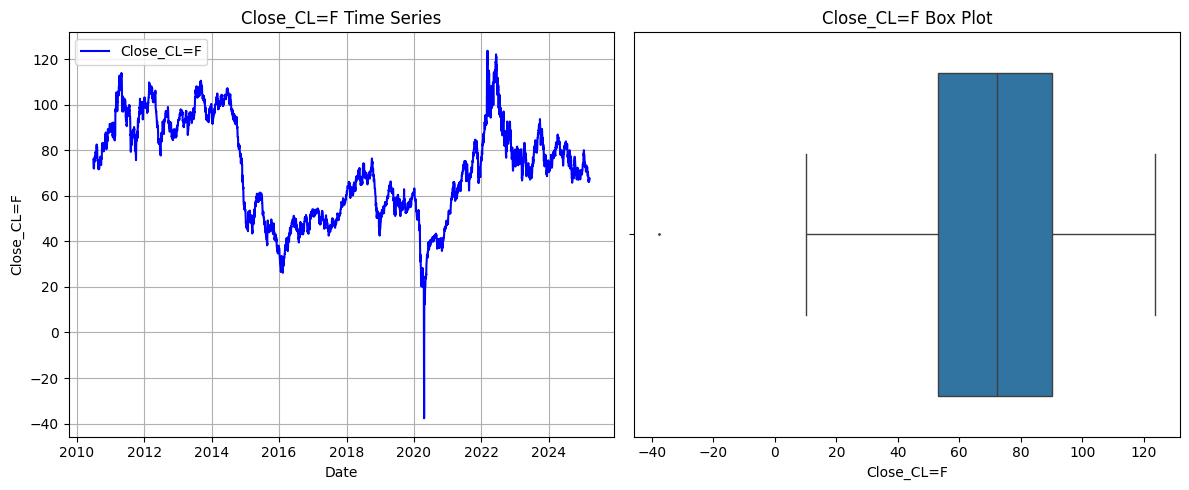

In [22]:
plots('Close_CL=F')

Negative outlier when crude oil futures went negative for the first time in history due to pandemic-related demand issues. Crude oil prices spiked sharply due to the Russia-Ukraine conflict and supply concerns. Hence these outliers are not a data issue.

In [23]:
# Checking outliers for 'Close_CL=F' WTI Crude Oil Futures
check_outliers = tsla_df[outliers["Close_^VIX"]]
check_outliers[['Close_^VIX']]

,Close_^VIX
Date,
2011-08-08,48.000000
2011-08-10,42.990002
2011-08-11,39.000000
2011-08-18,42.669998
2011-08-19,43.049999
2011-08-22,42.439999
2011-08-25,39.759998
2011-09-22,41.349998
2011-09-23,41.250000


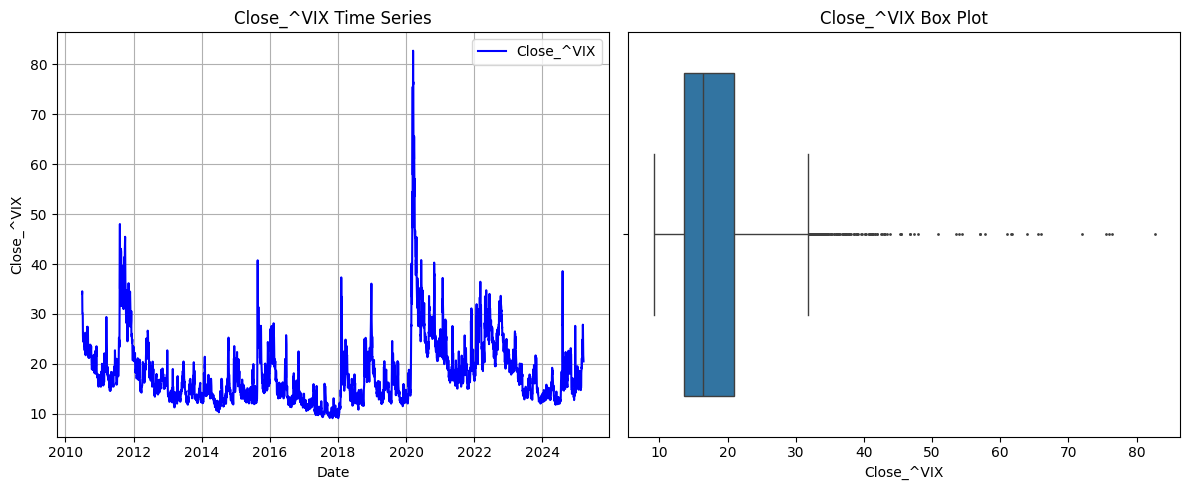

In [24]:
plots('Close_^VIX')

The sharp increase in March 2020 coincides with the global stock market crash caused by the pandemic.

In [25]:
# Checking outliers for 'Volume_^DJI'
check_outliers = tsla_df[outliers["Volume_^DJI"]]
check_outliers[['Volume_^DJI']]

,Volume_^DJI
Date,
2018-02-05,7.144500e+08
2018-02-06,8.239400e+08
2018-02-09,7.350300e+08
2018-12-21,9.005100e+08
2020-02-28,9.159900e+08
2020-03-09,7.504300e+08
2020-03-12,9.082600e+08
2020-03-13,8.430800e+08
2020-03-16,7.701300e+08


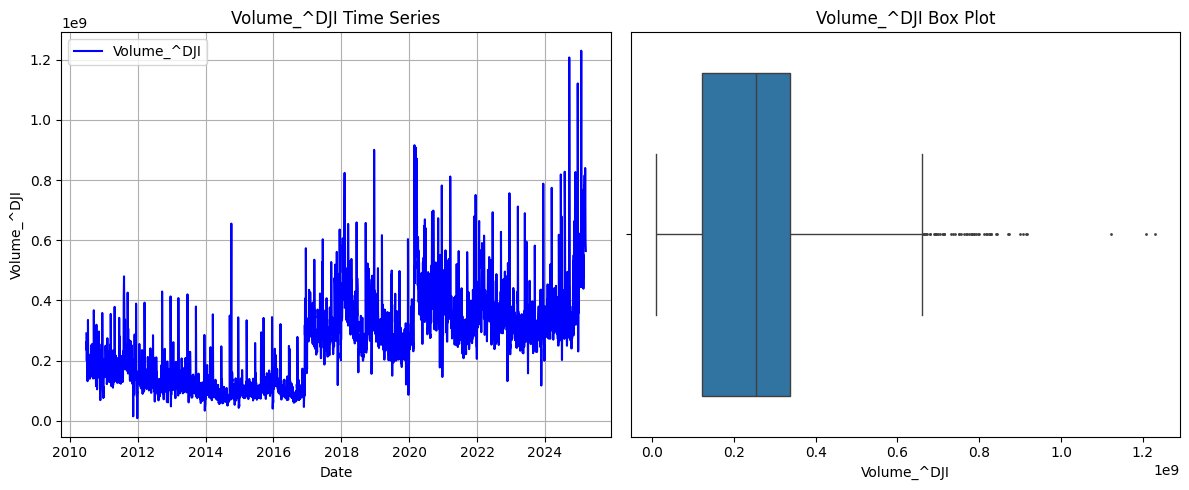

In [26]:
plots('Volume_^DJI')

These values are significantly higher than the typical volume range. But could correspond to the recent uncertainty in US market.

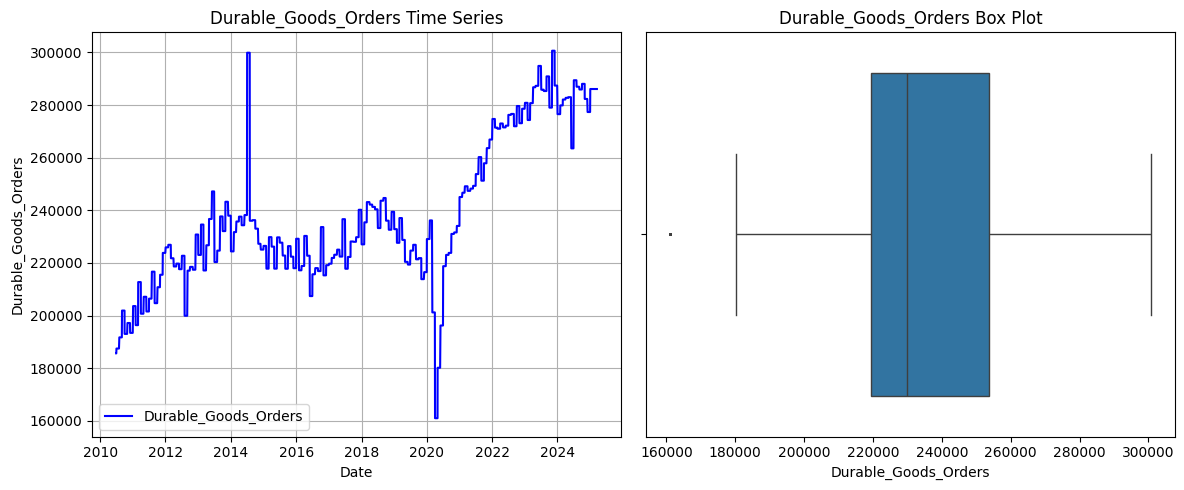

In [27]:
plots('Durable_Goods_Orders')

The COVID-19 market shock in 2020 explains the sharp decline in Durable Goods Orders.

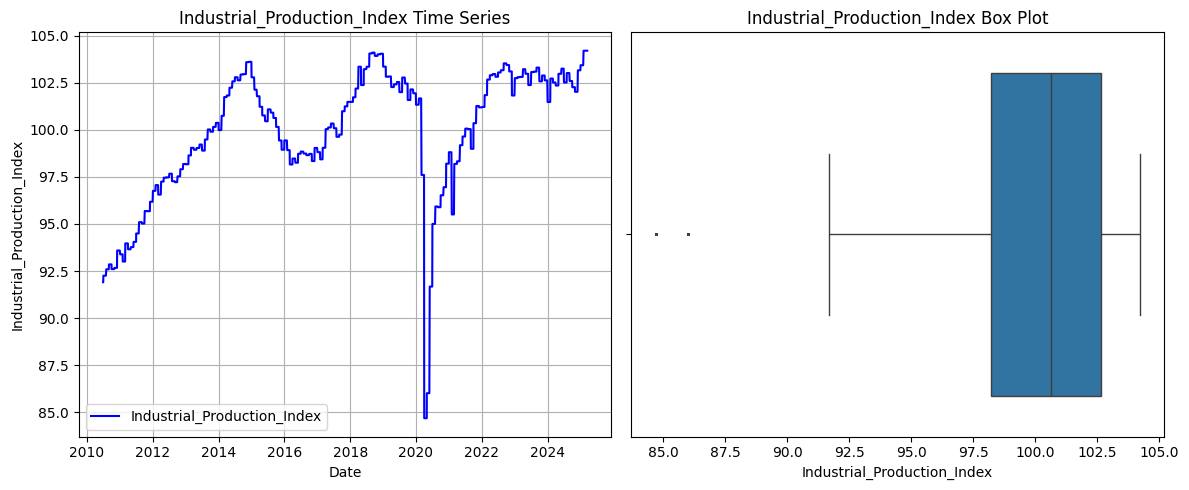

In [28]:
plots('Industrial_Production_Index')

The COVID-19 market shock in 2020 explains the sharp decline in Industrial Production.

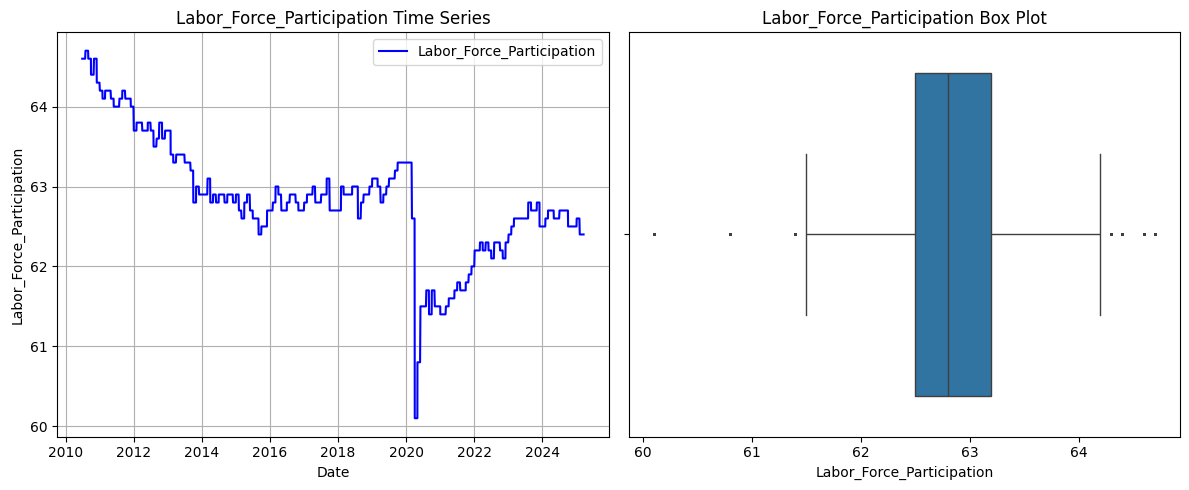

In [29]:
plots('Labor_Force_Participation')

The COVID-19 market shock in 2020 explains the sharp decline in Labor Force Participation.

In [30]:
# Extracting Clean and Merged Dataset
tsla_df.to_csv("/Users/emmanuel/Documents/Portfolio Projects/Tesla Stock Project/tsla_clean_dataset.csv", index=True)

### EDA - Feature engineering

In [31]:
tsla_df = pd.read_csv('/Users/emmanuel/Documents/Portfolio Projects/Tesla Stock Project/tsla_clean_dataset.csv')

In [32]:
# Function to create the label
def price_movement(row):
    if row['Close_TSLA'] > row['Open_TSLA']:
        return 1  # Price went up
    elif row['Close_TSLA'] < row['Open_TSLA']:
        return 0  # Price went down
    else: 
        return 99
    
# Apply the function to each row in the DataFrame
tsla_df['Label'] = tsla_df.apply(price_movement, axis=1)

In [33]:
# Get class balance of 'label' col
tsla_df['Label'].value_counts()

Label
0     1927
1     1906
99       7
Name: count, dtype: int64

7 rows where Open price = Close price

In [34]:
# Pulling the days where the close_tsla = open_tsla
nochange_df = tsla_df[tsla_df['Label'] == 99]
(nochange_df[['Date', 'Open_TSLA', 'Close_TSLA', 'Label']])

,Date,Open_TSLA,Close_TSLA,Label
73,2010-10-08,1.362000,1.362000,99
163,2011-02-11,1.550000,1.550000,99
441,2012-03-07,2.208000,2.208000,99
475,2012-04-24,2.121333,2.121333,99
528,2012-07-06,2.066000,2.066000,99
2470,2019-12-17,25.266001,25.266001,99
3419,2023-08-07,251.449997,251.449997,99


In [35]:
# Dropping the rows with open price = close price
tsla_df = tsla_df.query("Label != 99")
tsla_df['Label'].value_counts()

Label
0    1927
1    1906
Name: count, dtype: int64

#### Creating Economic Technical Indicators
* **SMA** (**Simple Moving Average**): The average closing price over a set period (e.g., 5 or 10 days) to smooth out price fluctuations and identify trends.

* **EMA** (**Exponential Moving Average**): A weighted moving average that gives more importance to recent prices, making it more responsive to price changes than SMA.

* **Bollinger Bands** (Upper & Lower Band): A volatility indicator consisting of a 20-day moving average (SMA) and two standard deviation bands, where wider bands indicate higher volatility.

* **RSI** (**Relative Strength Index**, 14-day): A momentum indicator (0-100 scale) that measures whether a stock is overbought (>70) or oversold (<30).

* **ATR** (**Average True Range**, 14-day): A volatility indicator that measures the average range between high and low prices over 14 days.

* **MACD** (**Moving Average Convergence Divergence**): A trend-following indicator that calculates the difference between the 12-day and 26-day EMAs to identify potential buy/sell signals.

* **MACD Signal Line**: A 9-day EMA of the MACD that helps confirm trend changes when crossed by the MACD line.

* **ROC** (**Rate of Change**, 14-day): A momentum indicator that shows the percentage change in price over the last 14 days, indicating strength or weakness in the trend.

In [36]:
# Moving Averages
tsla_df.loc[:, 'SMA_5'] = ta.trend.sma_indicator(tsla_df['Close_TSLA'], window=5)
tsla_df.loc[:, 'SMA_10'] = ta.trend.sma_indicator(tsla_df['Close_TSLA'], window=10)
tsla_df.loc[:, 'EMA_5'] = ta.trend.ema_indicator(tsla_df['Close_TSLA'], window=5)
tsla_df.loc[:, 'EMA_10'] = ta.trend.ema_indicator(tsla_df['Close_TSLA'], window=10)

In [37]:
# Compute Bollinger Bands safely with .loc[]
tsla_df.loc[:, 'Upper_Band'] = ta.volatility.bollinger_hband(tsla_df['Close_TSLA'], window=20)
tsla_df.loc[:, 'Lower_Band'] = ta.volatility.bollinger_lband(tsla_df['Close_TSLA'], window=20)

In [38]:
# Compute RSI correctly using the momentum module
tsla_df.loc[:, 'RSI_14'] = ta.momentum.rsi(tsla_df['Close_TSLA'], window=14)

In [39]:
# Average True Range (ATR)
tsla_df.loc[:, 'ATR_14'] = ta.volatility.average_true_range(tsla_df['High_TSLA'], tsla_df['Low_TSLA'], tsla_df['Close_TSLA'], window=14)

In [40]:
# Moving Average Convergence Divergence (MACD)
macd = ta.trend.macd(tsla_df['Close_TSLA'])
tsla_df.loc[:, 'MACD'] = macd
tsla_df.loc[:, 'Signal_Line'] = ta.trend.macd_signal(tsla_df['Close_TSLA'])

In [41]:
# Rate of Change (ROC)
tsla_df.loc[:, 'ROC_14'] = ta.momentum.roc(tsla_df['Close_TSLA'], window=14)

In [42]:
# Creating Lagged for Close & Open Price
tsla_df['Close_TSLA_Lag1'] = tsla_df['Close_TSLA'].shift(1)
tsla_df['Close_TSLA_Lag2'] = tsla_df['Close_TSLA'].shift(2)
tsla_df['Close_TSLA_Lag3'] = tsla_df['Close_TSLA'].shift(3)
tsla_df['Close_TSLA_Lag4'] = tsla_df['Close_TSLA'].shift(4)
tsla_df['Close_TSLA_Lag5'] = tsla_df['Close_TSLA'].shift(5)

tsla_df['Open_TSLA_Lag1'] = tsla_df['Open_TSLA'].shift(1)
tsla_df['Open_TSLA_Lag2'] = tsla_df['Open_TSLA'].shift(2)
tsla_df['Open_TSLA_Lag3'] = tsla_df['Open_TSLA'].shift(3)
tsla_df['Open_TSLA_Lag4'] = tsla_df['Open_TSLA'].shift(4)
tsla_df['Open_TSLA_Lag5'] = tsla_df['Open_TSLA'].shift(5)
(tsla_df[['Date', 'Close_TSLA_Lag1', 'Open_TSLA_Lag1']]).head()

,Date,Close_TSLA_Lag1,Open_TSLA_Lag1
0,2010-06-29,NaN,NaN
1,2010-06-30,1.592667,1.266667
2,2010-07-01,1.588667,1.719333
3,2010-07-02,1.464000,1.666667
4,2010-07-05,1.280000,1.533333


In [43]:
# Overnight price difference
tsla_df['Open_Close_Diff'] = tsla_df['Open_TSLA'] - tsla_df['Close_TSLA_Lag1']

In [44]:
# Volalitity 
tsla_df['Volatility'] = tsla_df['Open_Close_Diff'].rolling(window=5).std()

In [45]:
# Momentum
tsla_df['Momentum'] = tsla_df['Close_TSLA'] - tsla_df['Close_TSLA'].shift(5)

In [46]:
tsla_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3833 entries, 0 to 3839
Data columns (total 74 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         3833 non-null   object 
 1   Close_BTC-USD                2737 non-null   float64
 2   Close_BZ=F                   3833 non-null   float64
 3   Close_CL=F                   3833 non-null   float64
 4   Close_TSLA                   3833 non-null   float64
 5   Close_^DJI                   3833 non-null   float64
 6   Close_^GSPC                  3833 non-null   float64
 7   Close_^TNX                   3833 non-null   float64
 8   Close_^VIX                   3833 non-null   float64
 9   High_BTC-USD                 2737 non-null   float64
 10  High_BZ=F                    3833 non-null   float64
 11  High_CL=F                    3833 non-null   float64
 12  High_TSLA                    3833 non-null   float64
 13  High_^DJI              

In [47]:
# Extracting Feature Engineered Dataset
tsla_df.to_csv("/Users/emmanuel/Documents/Portfolio Projects/Tesla Stock Project/tsla_feature.csv", index=True)

## EDA - Analysis, Visualisation and Feature Selection

In [48]:
tsla_df = pd.read_csv('/Users/emmanuel/Documents/Portfolio Projects/Tesla Stock Project/tsla_feature.csv')
tsla_df.head()

,Unnamed: 0,Date,Close_BTC-USD,Close_BZ=F,Close_CL=F,Close_TSLA,Close_^DJI,Close_^GSPC,Close_^TNX,Close_^VIX,High_BTC-USD,High_BZ=F,High_CL=F,High_TSLA,High_^DJI,High_^GSPC,High_^TNX,High_^VIX,Low_BTC-USD,Low_BZ=F,Low_CL=F,Low_TSLA,Low_^DJI,Low_^GSPC,Low_^TNX,Low_^VIX,Open_BTC-USD,Open_BZ=F,Open_CL=F,Open_TSLA,Open_^DJI,Open_^GSPC,Open_^TNX,Open_^VIX,Volume_BTC-USD,Volume_BZ=F,Volume_CL=F,Volume_TSLA,Volume_^DJI,Volume_^GSPC,Volume_^TNX,Volume_^VIX,CPI,PPI,Unemployment_Rate,Consumer_Sentiment,Federal_Funds_Rate,Durable_Goods_Orders,Industrial_Production_Index,Labor_Force_Participation,Label,SMA_5,SMA_10,EMA_5,EMA_10,Upper_Band,Lower_Band,RSI_14,ATR_14,MACD,Signal_Line,ROC_14,Close_TSLA_Lag1,Close_TSLA_Lag2,Close_TSLA_Lag3,Close_TSLA_Lag4,Close_TSLA_Lag5,Open_TSLA_Lag1,Open_TSLA_Lag2,Open_TSLA_Lag3,Open_TSLA_Lag4,Open_TSLA_Lag5,Open_Close_Diff,Volatility,Momentum
0,0,2010-06-29,NaN,75.440002,75.940002,1.592667,9870.299805,1041.239990,2.967,34.130001,NaN,76.160004,78.320000,1.666667,10135.799805,1071.099976,3.001,35.389999,NaN,74.860001,75.209999,1.169333,9811.919922,1035.180054,2.956,31.219999,NaN,76.160004,78.150002,1.266667,10135.719727,1071.099976,2.994,31.219999,NaN,161.0,323267.0,281494500.0,290500000.0,6.136700e+09,0.0,0.0,217.199,183.5,9.4,76.0,0.18,185667.0,91.9033,64.6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2010-06-30,NaN,75.010002,75.629997,1.588667,9774.019531,1030.709961,2.951,34.540001,NaN,75.949997,76.830002,2.028000,9908.919922,1048.079956,2.988,34.630001,NaN,74.059998,74.389999,1.553333,9753.839844,1028.329956,2.947,31.740000,NaN,75.589996,75.459999,1.719333,9868.339844,1040.560059,2.954,33.950001,NaN,242.0,357752.0,257806500.0,235090000.0,5.067080e+09,0.0,0.0,217.199,183.5,9.4,76.0,0.18,185667.0,91.9033,64.6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.592667,NaN,NaN,NaN,NaN,1.266667,NaN,NaN,NaN,NaN,0.126666,NaN,NaN
2,2,2010-07-01,NaN,72.339996,72.949997,1.464000,9732.530273,1027.369995,2.927,32.860001,NaN,74.260002,75.400002,1.728000,9795.480469,1033.579956,2.945,37.580002,NaN,71.580002,72.050003,1.351333,9621.889648,1010.909973,2.883,32.720001,NaN,74.120003,75.370003,1.666667,9773.269531,1031.099976,2.929,34.410000,NaN,300.0,405081.0,123282000.0,262820000.0,6.435770e+09,0.0,0.0,217.605,184.1,9.4,67.8,0.18,187506.0,92.2549,64.6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.588667,1.592667,NaN,NaN,NaN,1.719333,1.266667,NaN,NaN,NaN,0.078000,NaN,NaN
3,3,2010-07-02,NaN,71.650002,72.139999,1.280000,9686.480469,1022.580017,2.979,30.120001,NaN,72.709999,73.379997,1.540000,9770.870117,1032.949951,2.990,31.879999,NaN,71.480003,71.620003,1.247333,9614.320312,1015.929993,2.909,29.350000,NaN,72.489998,72.669998,1.533333,9732.530273,1027.650024,2.945,31.709999,NaN,156.0,256171.0,77097000.0,199570000.0,3.968500e+09,0.0,0.0,217.605,184.1,9.4,67.8,0.18,187506.0,92.2549,64.6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.464000,1.588667,1.592667,NaN,NaN,1.666667,1.719333,1.266667,NaN,NaN,0.069333,NaN,NaN
4,4,2010-07-05,NaN,71.650002,72.139999,1.280000,9686.480469,1022.580017,2.979,30.120001,NaN,72.709999,73.379997,1.540000,9770.870117,1032.949951,2.990,31.879999,NaN,71.480003,71.620003,1.247333,9614.320312,1015.929993,2.909,29.350000,NaN,72.489998,72.669998,1.533333,9732.530273,1027.650024,2.945,31.709999,NaN,156.0,256171.0,77097000.0,199570000.0,3.968500e+09,0.0,0.0,217.605,184.1,9.4,67.8,0.18,187506.0,92.2549,64.6,0,1.441067,NaN,1.399506,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.280000,1.464000,1.588667,1.592667,NaN,1.533333,1.666667,1.719333,1.266667,NaN,0.253333,NaN,NaN


In [49]:
# Drop the 'Unnamed: 0' column
tsla_df = tsla_df.drop(columns=['Unnamed: 0'])

# Set 'Date' as the index
tsla_df = tsla_df.set_index('Date')

In [50]:
tsla_df.index = pd.to_datetime(tsla_df.index)

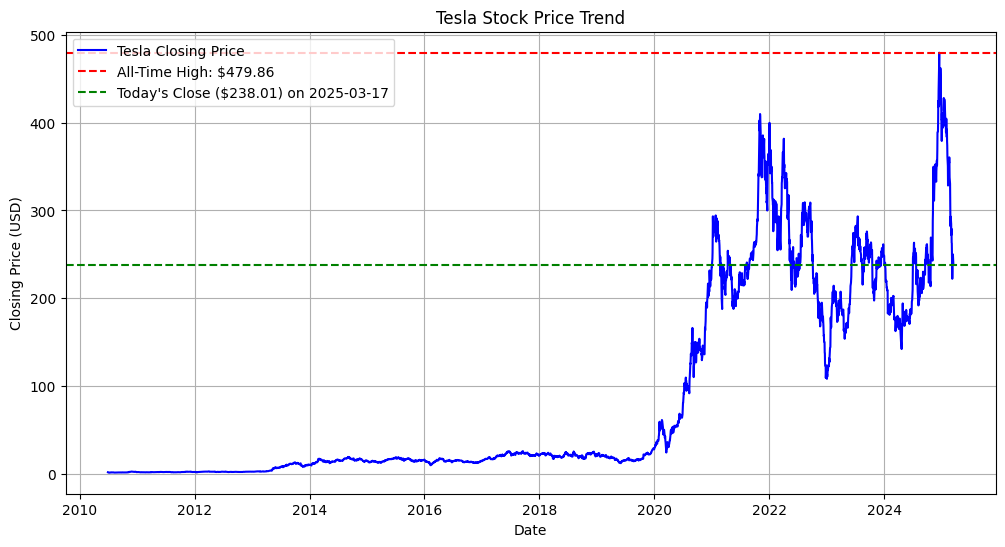

In [51]:
# All-Time High
all_time_high = tsla_df['Close_TSLA'].max()

# Latest price
todays_closing_price = tsla_df['Close_TSLA'].iloc[-1]
todays_date = tsla_df.index[-1].strftime('%Y-%m-%d') 

# Plot the Closing Price Trend
plt.figure(figsize=(12, 6))
plt.plot(tsla_df.index, tsla_df['Close_TSLA'], color='blue', label="Tesla Closing Price")

# Formatting the plot
plt.axhline(y=all_time_high, color='red', linestyle='--', label=f"All-Time High: ${all_time_high:.2f}")
plt.axhline(y=todays_closing_price, color='green', linestyle='--', label=f"Today's Close (${todays_closing_price:.2f}) on {todays_date}")
plt.title("Tesla Stock Price Trend")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid()

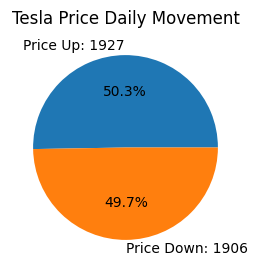

In [52]:
# Pie chart

fig = plt.figure(figsize=(3,3))
data=tsla_df['Label'].value_counts()
plt.pie(data, labels=[f"Price Up: {data.values[0]}", 
                     f"Price Down: {data.values[1]}"], 
                     autopct='%1.1f%%'
                     )
plt.title('Tesla Price Daily Movement');

Text(0.5, 1.0, 'Tesla vs WTI Crude Oil Prices')

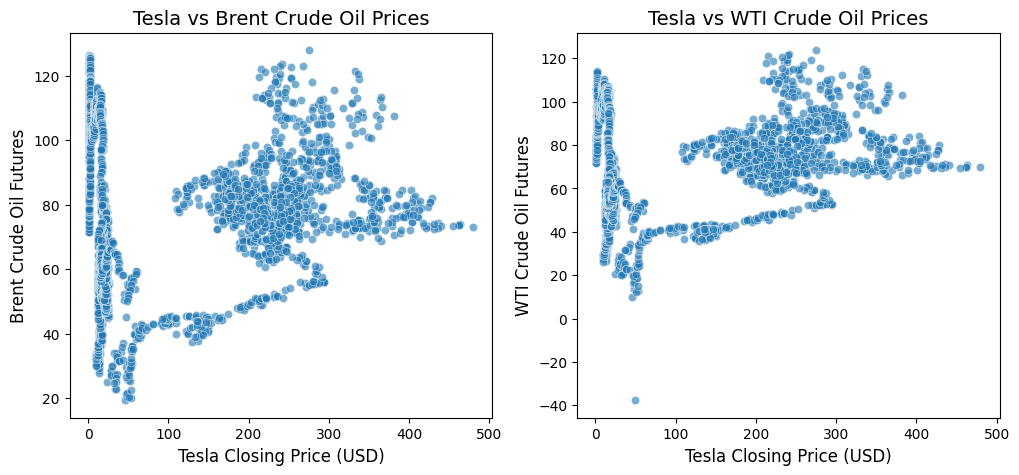

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Creating a scatter plot
sns.scatterplot(data=tsla_df, x='Close_TSLA', y='Close_BZ=F', alpha=0.6, ax=axes[0])
axes[0].set_xlabel("Tesla Closing Price (USD)", fontsize=12)
axes[0].set_ylabel("Brent Crude Oil Futures", fontsize=12)
axes[0].set_title("Tesla vs Brent Crude Oil Prices", fontsize=14)

sns.scatterplot(data=tsla_df, x='Close_TSLA', y='Close_CL=F', alpha=0.6, ax=axes[1])
axes[1].set_xlabel("Tesla Closing Price (USD)", fontsize=12)
axes[1].set_ylabel("WTI Crude Oil Futures", fontsize=12)
axes[1].set_title("Tesla vs WTI Crude Oil Prices", fontsize=14)

Tesla vs Brent Crude - There appears to be a positive correlation, but with significant dispersion.

Tesla vs WTI Crude Oil - positive correlation is visible but with a notable spread, a few outliers exist which we observed earlier from pandemic.

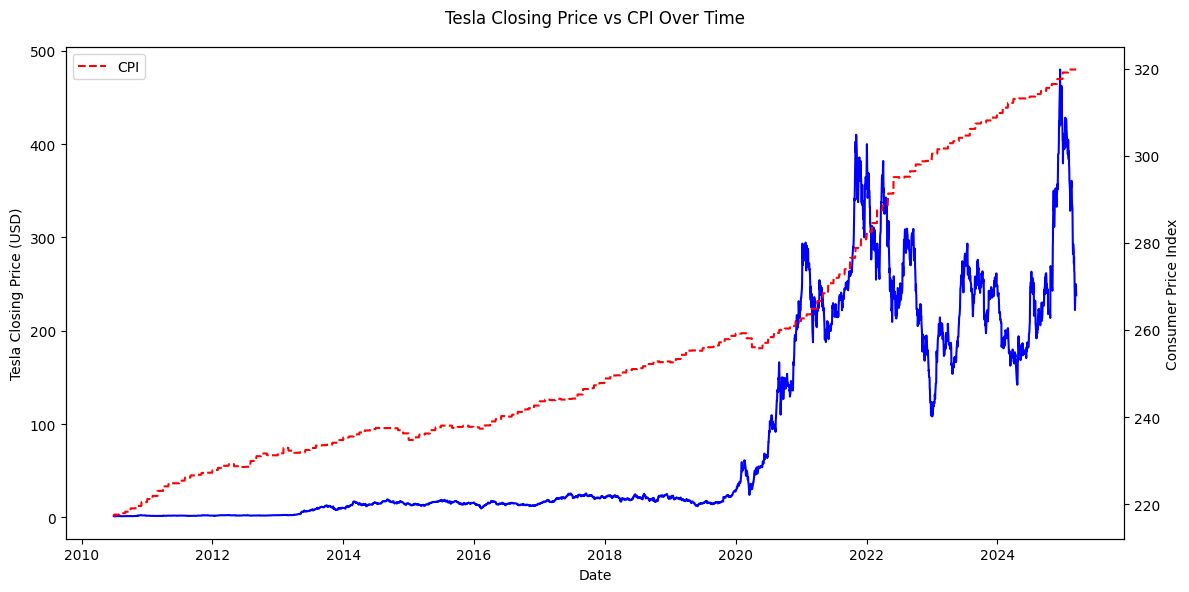

In [54]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot Tesla Closing Price
ax1.set_xlabel('Date')
ax1.set_ylabel('Tesla Closing Price (USD)')
ax1.plot(tsla_df.index, tsla_df['Close_TSLA'], color='blue', label="Tesla Closing Price")

# Create a secondary y-axis for CPI
ax2 = ax1.twinx()
ax2.set_ylabel('Consumer Price Index')
ax2.plot(tsla_df.index, tsla_df['CPI'], color='red', linestyle='dashed', label="CPI")

fig.suptitle("Tesla Closing Price vs CPI Over Time")
fig.tight_layout()
plt.legend()

Tesla's stock exploded after 2020, aligning with a steady increase in CPI.

Tesla’s Price Showed High Volatility While CPI Increased Gradually.

CPI followed a smooth, long-term upward trend (inflation increases prices over time).

Tesla, on the other hand, experienced sharp spikes and crashes.

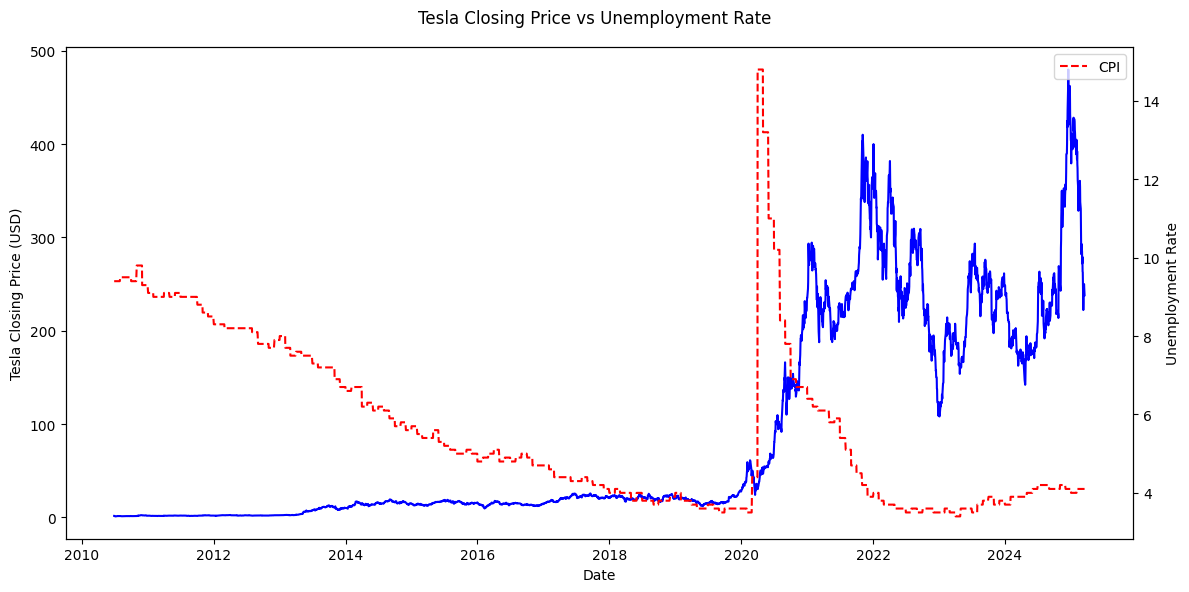

In [55]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot Tesla Closing Price
ax1.set_xlabel('Date')
ax1.set_ylabel('Tesla Closing Price (USD)')
ax1.plot(tsla_df.index, tsla_df['Close_TSLA'], color='blue', label="Tesla Closing Price")

# Create a secondary y-axis for CPI
ax2 = ax1.twinx()
ax2.set_ylabel('Unemployment Rate')
ax2.plot(tsla_df.index, tsla_df['Unemployment_Rate'], color='red', linestyle='dashed', label="CPI")

fig.suptitle("Tesla Closing Price vs Unemployment Rate")
fig.tight_layout()
plt.legend()

Huge Unemployment Spike in 2020

After the 2020 peak, unemployment declined steadily, which aligned with Tesla’s massive rally. This suggests that economic recovery & job growth boosted investor confidence, leading to more demand for Tesla stock.

Unemployment rates stabilized between 3-5%, while Tesla’s price showed higher volatility. This indicates that other macroeconomic factors are driving Tesla’s stock in recent years rather than unemployment alone.

### Feature Selection

Text(0.5, 1.0, 'Correlation Matrix of Tesla and Price Related Variables')

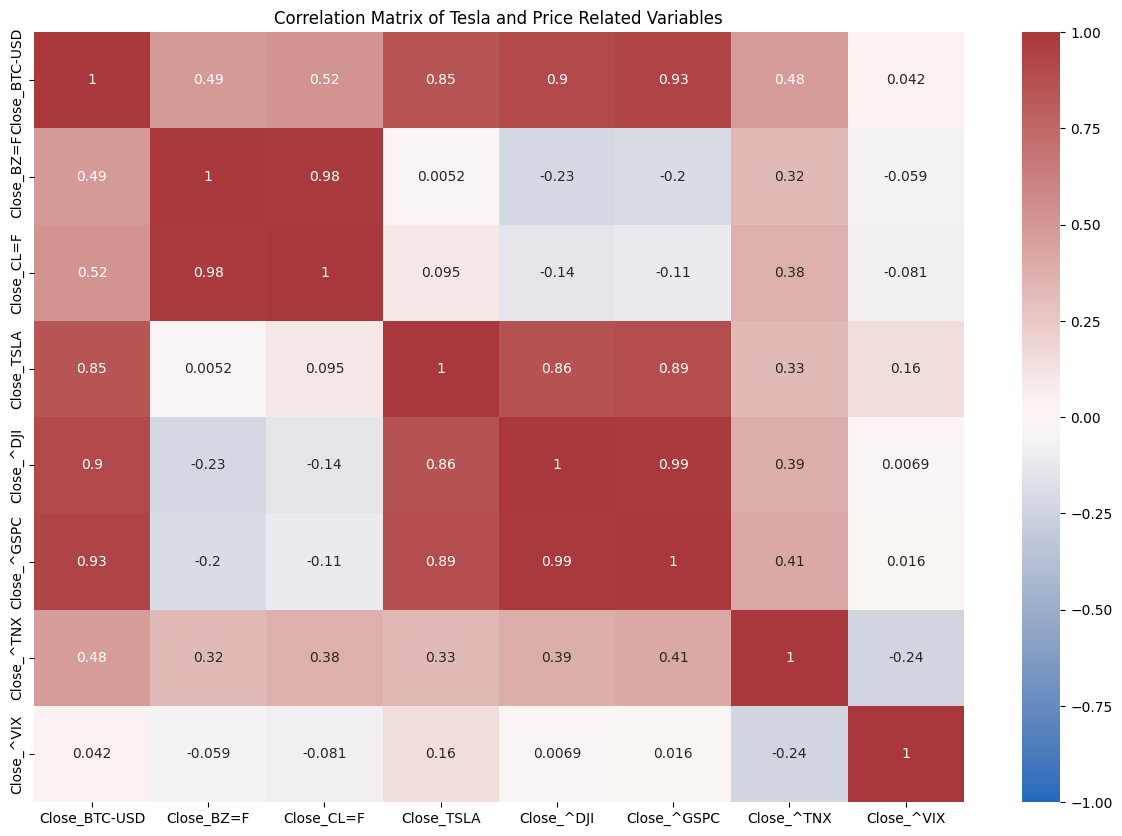

In [56]:
close_corr_matrix = tsla_df[['Close_BTC-USD', 'Close_BZ=F', 'Close_CL=F', 'Close_TSLA', 'Close_^DJI', 'Close_^GSPC', 'Close_^TNX', 'Close_^VIX']].corr()

# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(close_corr_matrix, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
plt.title("Correlation Matrix of Tesla and Price Related Variables")

Dropping 'Close_CL=F' WTI Crude Oil Futures highly correlated with 'Close_BZ=F' Brent Crude Oil Futures at 0.99. Keeping 'Close_BZ=F' is global benchmark where as 'Close_CL=F' is more a US benchmark.

Removing 'Close_^DJI' Dow Jones & 'Close_^GSPC' S&P 500 0.99 correlated to each other also highly correlated with BTC and Close_TSLA and we are keeping both of these also TSLA makes us S&P 500 so price movements already reflected.

In [57]:
tsla_feature_selection = tsla_df.drop(columns=['Close_CL=F', 'Close_^DJI', 'Close_BTC-USD'])

Text(0.5, 1.0, 'Correlation Matrix of Tesla and Volume Related Variables')

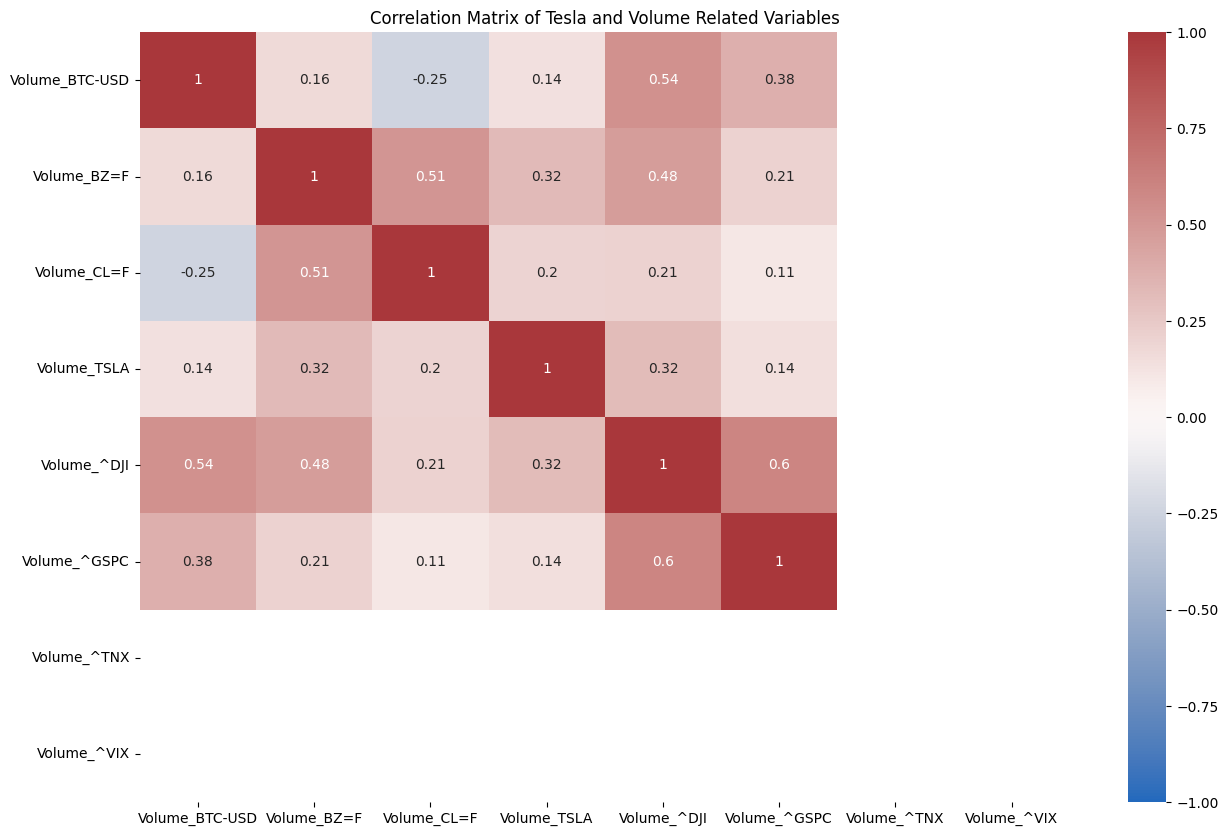

In [58]:
vol_corr_matrix = tsla_df[['Volume_BTC-USD', 'Volume_BZ=F', 'Volume_CL=F', 'Volume_TSLA', 'Volume_^DJI', 'Volume_^GSPC', 'Volume_^TNX', 'Volume_^VIX']].corr()

# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(vol_corr_matrix, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
plt.title("Correlation Matrix of Tesla and Volume Related Variables")

No features need to be dropped here no multicollinearity

Text(0.5, 1.0, 'Correlation Matrix of Tesla and Macroeconomic Related Variables')

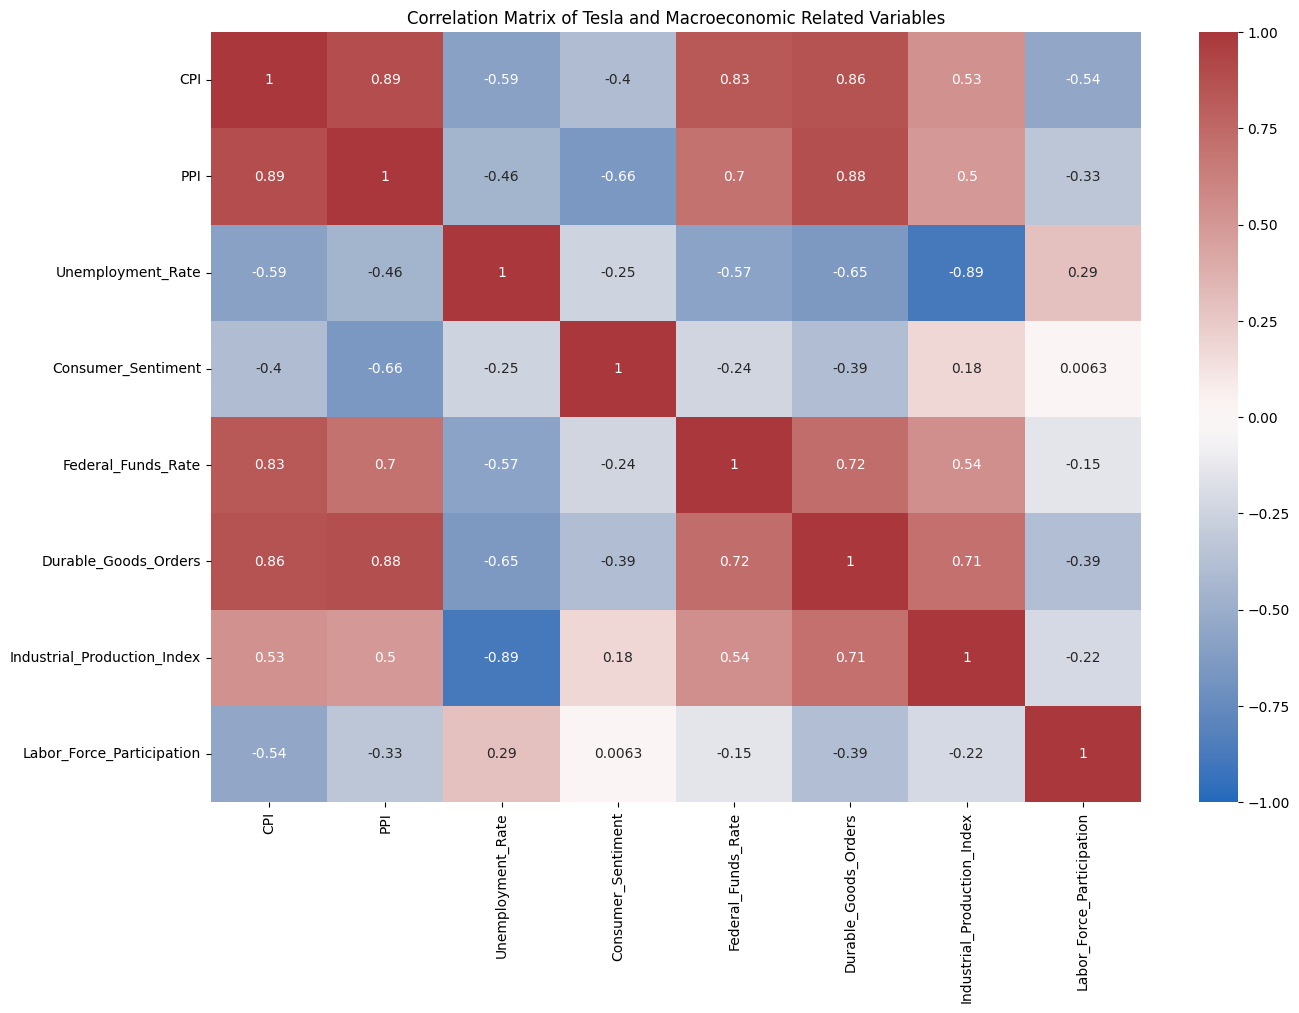

In [59]:
macro_corr_matrix = tsla_df[['CPI', 'PPI', 'Unemployment_Rate', 'Consumer_Sentiment', 'Federal_Funds_Rate', 'Durable_Goods_Orders', 'Industrial_Production_Index', 
                             'Labor_Force_Participation']].corr()

# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(macro_corr_matrix, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
plt.title("Correlation Matrix of Tesla and Macroeconomic Related Variables")

CPI and PPI are highly correlated at 0.94 and also similarly correlated with Consumer Sentiment and Federal Funds Rate which are being kept because they are not has highly correlated. 

Durable Goods Orders highly correlated with several features so removing 

Industrial Production Index highly correlated with unemployment rate so removing as keeping unemployment rate.

In [60]:
tsla_feature_selection = tsla_feature_selection.drop(columns=['CPI', 'PPI', 'Durable_Goods_Orders', 'Industrial_Production_Index'])

Text(0.5, 1.0, 'Correlation Matrix of Tesla and Technical Related Variables')

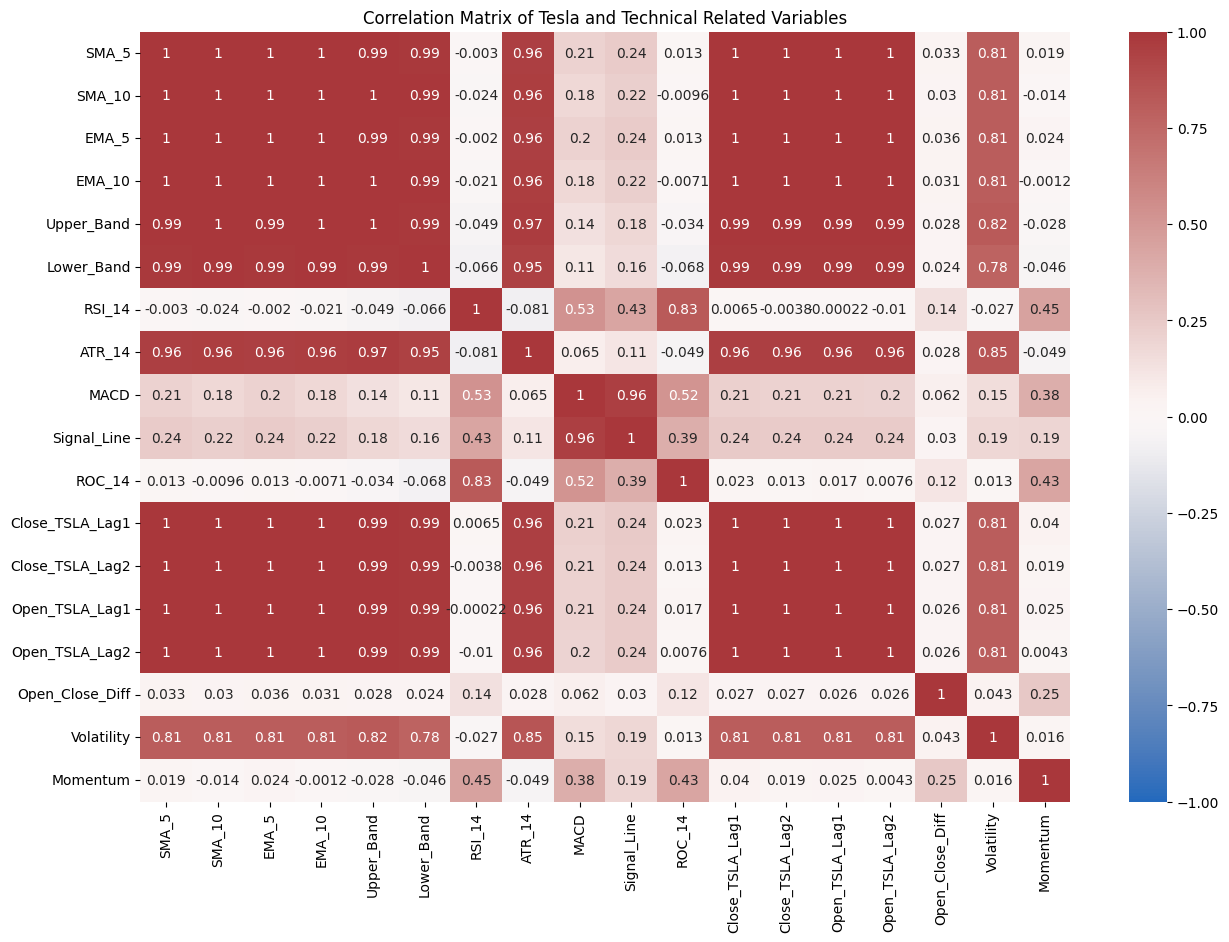

In [61]:
tech_corr_matrix = tsla_df[['SMA_5', 'SMA_10', 'EMA_5', 'EMA_10', 'Upper_Band', 'Lower_Band', 'RSI_14', 'ATR_14', 'MACD', 'Signal_Line', 'ROC_14',
                             'Close_TSLA_Lag1', 'Close_TSLA_Lag2', 'Open_TSLA_Lag1', 'Open_TSLA_Lag2', 'Open_Close_Diff', 'Volatility', 'Momentum']].corr()

# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(tech_corr_matrix, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
plt.title("Correlation Matrix of Tesla and Technical Related Variables")

A lot of highly correlated feature as a lot of these rolling calculations were built of the close price. Removing highly correlated variables

In [62]:
tsla_feature_selection = tsla_feature_selection.drop(columns=['SMA_5', 'SMA_10', 'EMA_5', 'EMA_10', 'Upper_Band', 'Lower_Band', 'ATR_14', 'Signal_Line',
                             'Close_TSLA_Lag1', 'Close_TSLA_Lag2', 'Close_TSLA_Lag3', 'Close_TSLA_Lag4', 'Close_TSLA_Lag5', 
                             'Open_TSLA_Lag1', 'Open_TSLA_Lag2', 'Open_TSLA_Lag3', 'Open_TSLA_Lag4', 'Open_TSLA_Lag5', 'Close_TSLA', 
                             'Close_^TNX', 'Close_BZ=F'])

In [63]:
# Removing High Open Low prices are these are redundant features 
tsla_feature_selection = tsla_feature_selection.drop(columns=['High_BTC-USD', 'High_BZ=F', 'High_CL=F', 'High_TSLA', 'High_^DJI', 'High_^GSPC', 'High_^TNX', 'High_^VIX',
                                                              'Low_BTC-USD', 'Low_BZ=F', 'Low_CL=F', 'Low_TSLA', 'Low_^DJI', 'Low_^GSPC', 'Low_^TNX', 'Low_^VIX',
                                                               'Open_BTC-USD', 'Open_BZ=F', 'Open_CL=F', 'Open_TSLA', 'Open_^DJI', 'Open_^GSPC', 'Open_^TNX', 'Open_^VIX',
                                                                'Volume_BTC-USD' ])

In [64]:
tsla_feature_selection = tsla_feature_selection.drop(columns=['Consumer_Sentiment', 'Unemployment_Rate', 'Federal_Funds_Rate', 'Labor_Force_Participation'])

Text(0.5, 1.0, 'Correlation Matrix of Tesla and Related Variables')

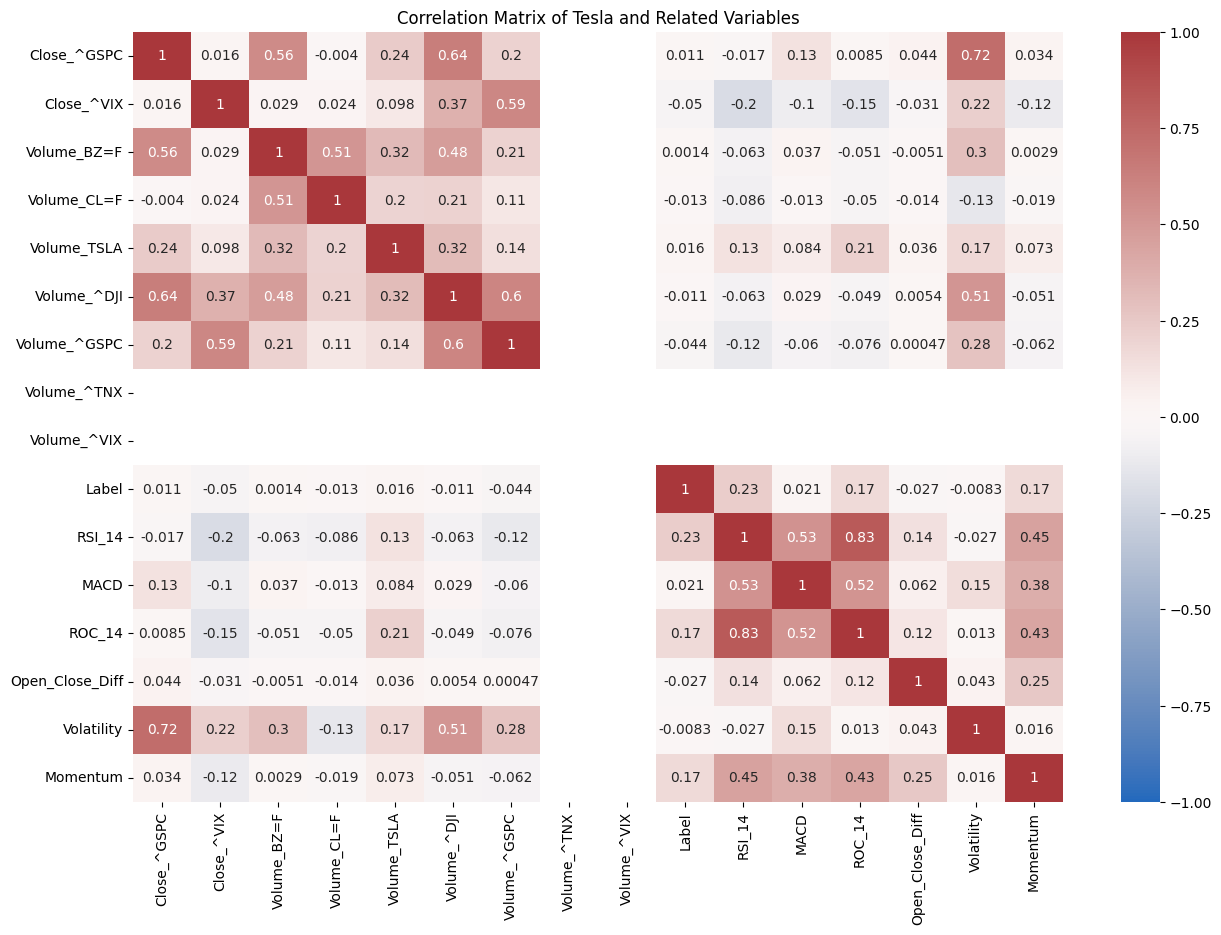

In [65]:
tsla_feature_selection_matrix = tsla_feature_selection.corr()

# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(tsla_feature_selection_matrix, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
plt.title("Correlation Matrix of Tesla and Related Variables")

In [66]:
# Drop NaN values by rolling calculations
tsla_feature_selection = tsla_feature_selection.dropna()

In [67]:
tsla_feature_selection.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3808 entries, 2010-08-03 to 2025-03-17
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Close_^GSPC      3808 non-null   float64
 1   Close_^VIX       3808 non-null   float64
 2   Volume_BZ=F      3808 non-null   float64
 3   Volume_CL=F      3808 non-null   float64
 4   Volume_TSLA      3808 non-null   float64
 5   Volume_^DJI      3808 non-null   float64
 6   Volume_^GSPC     3808 non-null   float64
 7   Volume_^TNX      3808 non-null   float64
 8   Volume_^VIX      3808 non-null   float64
 9   Label            3808 non-null   int64  
 10  RSI_14           3808 non-null   float64
 11  MACD             3808 non-null   float64
 12  ROC_14           3808 non-null   float64
 13  Open_Close_Diff  3808 non-null   float64
 14  Volatility       3808 non-null   float64
 15  Momentum         3808 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 505

In [68]:
# Extracting Feature Selection Dataset
tsla_feature_selection.to_csv("/Users/emmanuel/Documents/Portfolio Projects/Tesla Stock Project/tsla_feature_selection.csv", index=True)

## Modelling

In [69]:
tsla_df = pd.read_csv('/Users/emmanuel/Documents/Portfolio Projects/Tesla Stock Project/tsla_feature_selection.csv')
tsla_df.head()

,Date,Close_^GSPC,Close_^VIX,Volume_BZ=F,Volume_CL=F,Volume_TSLA,Volume_^DJI,Volume_^GSPC,Volume_^TNX,Volume_^VIX,Label,RSI_14,MACD,ROC_14,Open_Close_Diff,Volatility,Momentum
0,2010-08-03,1120.459961,22.629999,270.0,290979.0,18457500.0,164880000.0,4.071820e+09,0.0,0.0,1,56.969773,-0.007029,10.635028,0.005333,0.017848,0.093333
1,2010-08-04,1127.239990,22.209999,219.0,293321.0,13695000.0,173360000.0,4.057850e+09,0.0,0.0,0,52.488001,-0.003484,6.887861,0.000000,0.017848,0.036000
2,2010-08-05,1125.810059,22.100000,54.0,234811.0,11943000.0,139610000.0,3.685560e+09,0.0,0.0,0,47.740024,-0.004975,-0.920571,0.018667,0.018328,0.006666
3,2010-08-06,1121.640015,21.740000,264.0,397532.0,11128500.0,154870000.0,3.857890e+09,0.0,0.0,0,43.265138,-0.010660,-10.588794,-0.023333,0.022507,-0.023333
4,2010-08-09,1127.790039,22.139999,156.0,267083.0,12190500.0,166330000.0,3.979360e+09,0.0,0.0,0,43.331685,-0.014939,-3.448229,0.020667,0.017730,-0.088000


In [70]:
# Select features
X = tsla_df.drop(columns=['Label', 'Date'])

# Isolate y variable
y = tsla_df['Label']

### Logistic Regression

In [71]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training data, transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  

In [72]:
# Logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train_scaled, y_train)

In [73]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test_scaled)

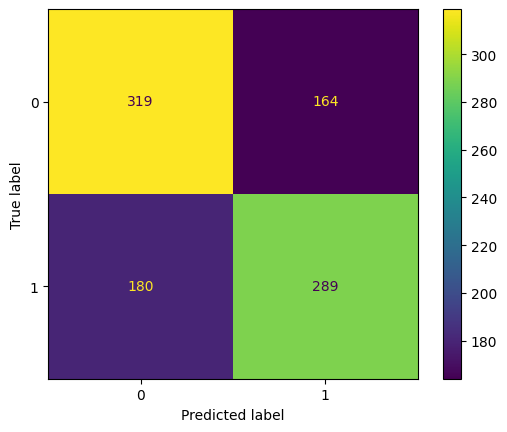

In [74]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

In [75]:
# Create classification report for logistic regression model
target_names = ['Predicted Price Down', 'Predicted Price Up']
print(classification_report(y_test, y_pred, target_names=target_names))

                      precision    recall  f1-score   support

Predicted Price Down       0.64      0.66      0.65       483
  Predicted Price Up       0.64      0.62      0.63       469

            accuracy                           0.64       952
           macro avg       0.64      0.64      0.64       952
        weighted avg       0.64      0.64      0.64       952



64% Accuracy.

Balanced Performance – The precision, recall, and F1-score are fairly similar for both price-up and price-down predictions, meaning the model isn't heavily biased towards one class.

164 false positives - 175 Predicted Price to go up but the price went down.

180 false negatives - 163 Predicted price to down but the price went up.

### Random Forest

In [76]:
# Random forest classifier
rf = RandomForestClassifier(random_state=42)

# Hyperparameters to tune
cv_params = {
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', None], 
    'max_samples': [0.8, 1.0],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5, 10], 
    'n_estimators': [100, 300, 500],
}

# Scoring Metrics for GridSearch to capture (precision, recall, F1 score and accuracy)
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='accuracy', n_jobs=-1)

In [ ]:
# Fit the model to the training data
rf_cv.fit(X_train, y_train)

In [ ]:
# Define a path to the folder where you want to save the model
path = ''

In [ ]:
# Pickle the model
with open(path+'rf_cv_model.pickle', 'wb') as to_write:
    pickle.dump(rf_cv, to_write)

In [78]:
# Read in pickled model
with open(path + 'rf_cv_model1.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

In [79]:
# Best score
rf_cv.best_score_

np.float64(0.6367775831873905)

This model has an accuracy score of 63.68%

In [80]:
# Best hyperparameter combination
rf_cv.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

In [81]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_accuracy'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )

    return table

In [82]:
# Make a results table for the rf_cv model using above function
results = make_results('Random Forest Cross Validation', rf_cv)
results

,Model,F1,Recall,Precision,Accuracy
0,Random Forest Cross Validation,0.641767,0.645584,0.638689,0.636778


Text(0.5, 0, 'Importance')

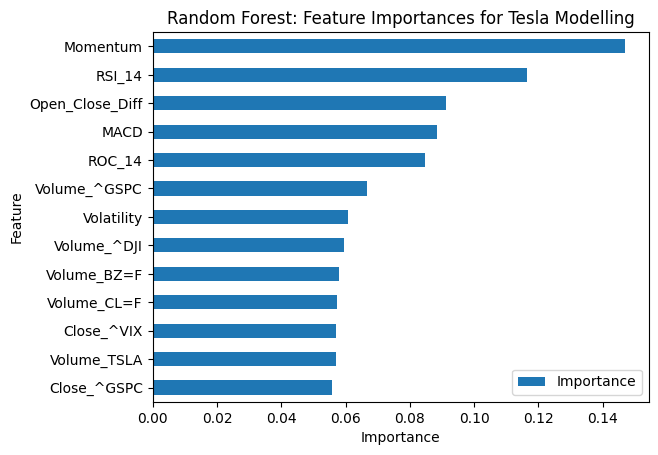

In [83]:
# Get feature importances
feat_impt = rf_cv.best_estimator_.feature_importances_

# Get indices of top 20 features
ind = np.argpartition(rf_cv.best_estimator_.feature_importances_, -13)[-13:]

# Get column labels of top 20 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 20 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Tesla Modelling", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

## XGBoost Modelling

In [84]:
# XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)


cv_params = {
    'learning_rate': [0.04, 0.05, 0.06],
    'n_estimators': [150, 200, 250],
    'max_depth': [5, 6, 7],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.5, 1]
}

# Define Scoring Metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate GridSearchCV
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='accuracy', n_jobs=-1)

In [ ]:
# Fit the model
xgb_cv.fit(X_train, y_train)

In [ ]:
# Pickle the model
with open(path + 'xgb_cv_model1.pickle', 'wb') as to_write:
    pickle.dump(xgb_cv, to_write) 

In [85]:
# Open pickled model
with open(path+'xgb_cv_model1.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

In [86]:
# Examine best score
xgb_cv.best_score_

np.float64(0.6434325744308231)

This model has an accuracy score of 64.34

In [87]:
# Examine best score
xgb_cv.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.06,
 'max_depth': 5,
 'min_child_weight': 2,
 'n_estimators': 250,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'subsample': 0.8}

In [88]:
# Create xgb model results table
xgb_cv_results = make_results('XGBoost Cross Validated', xgb_cv)
xgb_cv_results

,Model,F1,Recall,Precision,Accuracy
0,XGBoost Cross Validated,0.647484,0.649768,0.645344,0.643433


In [89]:
# Concatentate model results table with master results table
results = pd.concat([xgb_cv_results, results])
# Sort master results by accuracy score in descending order
results.sort_values(by=['Accuracy'], ascending=False)
results

,Model,F1,Recall,Precision,Accuracy
0,XGBoost Cross Validated,0.647484,0.649768,0.645344,0.643433
0,Random Forest Cross Validation,0.641767,0.645584,0.638689,0.636778


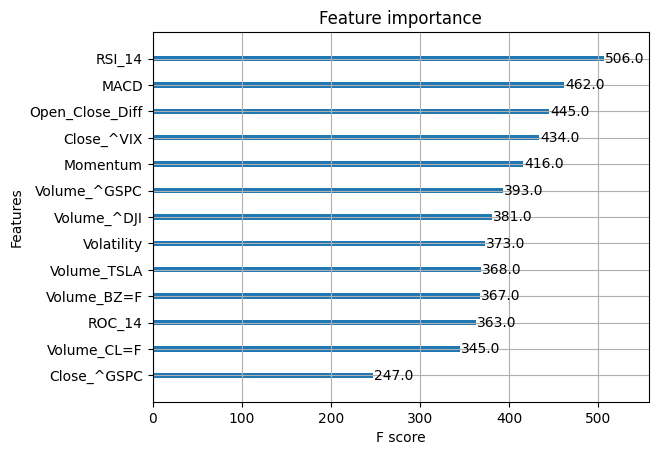

In [90]:
plot_importance(xgb_cv.best_estimator_);

In [91]:
# Drop least important features & re-train
X_train_reduced = X_train.drop(columns=['Close_^GSPC'])
X_test_reduced = X_test.drop(columns=['Close_^GSPC'])

# Re-train XGBoost
xgb_cv.best_estimator_.fit(X_train_reduced, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [92]:
y_test_pred_reduced = xgb_cv.best_estimator_.predict(X_test_reduced)

# Compare new scores
print("XGBoost Performance After Feature Reduction:")
print(classification_report(y_test, y_test_pred_reduced))

XGBoost Performance After Feature Reduction:
              precision    recall  f1-score   support

           0       0.66      0.65      0.66       483
           1       0.65      0.66      0.65       469

    accuracy                           0.66       952
   macro avg       0.66      0.66      0.66       952
weighted avg       0.66      0.66      0.66       952



66% Accuracy this our champion model

In [93]:
# Predict on test data
xgb_cv_preds = xgb_cv.best_estimator_.predict(X_test_reduced)
print('F1 score final XGB model: ', f1_score(y_test, xgb_cv_preds))
print('Recall score final XGB model: ', recall_score(y_test, xgb_cv_preds))
print('Precision score final XGB model: ', precision_score(y_test, xgb_cv_preds))
print('Accuracy score final XGB model: ', accuracy_score(y_test, xgb_cv_preds))

F1 score final XGB model:  0.652542372881356
Recall score final XGB model:  0.6567164179104478
Precision score final XGB model:  0.6484210526315789
Accuracy score final XGB model:  0.6554621848739496


Accuracy Increased from 64.3% → 65.6% after removing Close_^GSPC.

In [ ]:
# Pickle the model
with open(path + 'xgb_cv_model1.pickle', 'wb') as to_write:
    pickle.dump(xgb_cv, to_write) 

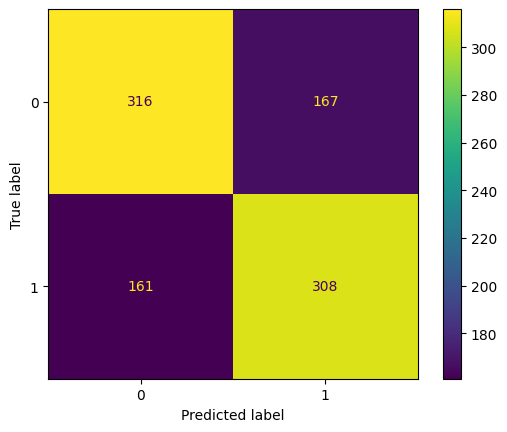

In [94]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, xgb_cv_preds, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

In [ ]:
plot_importance(xgb_cv.best_estimator_);

## Model Deployment

In [92]:
tsla_df = pd.read_csv('/Users/emmanuel/Documents/Portfolio Projects/Tesla Stock Project/tsla_feature_selection.csv')
tsla_df.tail()

,Date,Close_^GSPC,Close_^VIX,Volume_BZ=F,Volume_CL=F,Volume_TSLA,Volume_^DJI,Volume_^GSPC,Volume_^TNX,Volume_^VIX,Label,RSI_14,MACD,ROC_14,Open_Close_Diff,Volatility,Momentum
3807,2025-03-17,5675.120117,20.510000,29314.0,161298.0,111900600.0,5.641900e+08,5.031770e+09,0.0,0.0,0,31.587324,-32.864012,-21.396960,-4.919998,8.095670,15.860001
3808,2025-03-18,5614.660156,21.700001,32008.0,110338.0,111477600.0,5.698100e+08,4.666270e+09,0.0,0.0,0,29.162591,-33.155118,-22.520630,-9.849991,10.337921,-5.270004
3809,2025-03-19,5675.290039,19.900000,26898.0,73077.0,111993800.0,5.775300e+08,4.660090e+09,0.0,0.0,1,33.714595,-32.163761,-16.346873,6.300003,7.145441,-12.229996
3810,2025-03-20,5662.890137,19.799999,33049.0,283376.0,99028300.0,5.452400e+08,4.678420e+09,0.0,0.0,1,33.888057,-30.988610,-19.359688,-2.509995,7.200544,-4.419998
3811,2025-03-21,5667.560059,19.280001,33049.0,283376.0,132211300.0,1.026600e+09,9.367460e+09,0.0,0.0,1,39.219591,-28.721597,-12.626028,-1.269989,5.891081,-1.269989


In [99]:
# Get the latest available date
latest_date = tsla_df['Date'].max()

# Filter data for the latest available date
latest_data = tsla_df[tsla_df['Date'] == latest_date]
latest_data

,Date,Close_^GSPC,Close_^VIX,Volume_BZ=F,Volume_CL=F,Volume_TSLA,Volume_^DJI,Volume_^GSPC,Volume_^TNX,Volume_^VIX,Label,RSI_14,MACD,ROC_14,Open_Close_Diff,Volatility,Momentum
3811,2025-03-21,5667.560059,19.280001,33049.0,283376.0,132211300.0,1.026600e+09,9.367460e+09,0.0,0.0,1,39.219591,-28.721597,-12.626028,-1.269989,5.891081,-1.269989


In [100]:
latest_data = latest_data.drop(columns=['Label', 'Date', 'Close_^GSPC'])

In [ ]:
# Define a path to the folder where you want to save the model
path = ''

In [96]:
# Read in pickled model
with open(path + 'final_xgboost_model.pickle', 'rb') as to_read:
    final_xgboost_model = pickle.load(to_read)

In [108]:
# Get prediction probabilities
tomorrow_probabilities = final_xgboost_model.predict_proba(latest_data)

# Confidence percentage for the predicted class
confidence_percentage = max(tomorrow_probabilities[0]) * 100  # Convert to percentage

# Get the predicted class
tomorrow_prediction = final_xgboost_model.predict(latest_data)[0]

# Interpret prediction with confidence
if tomorrow_prediction == 1:
    print(f" Prediction: Tesla's stock price is expected to INCREASE tomorrow with {confidence_percentage:.2f}% confidence.")
else:
    print(f" Prediction: Tesla's stock price is expected to DECREASE tomorrow with {confidence_percentage:.2f}% confidence.")


 Prediction: Tesla's stock price is expected to INCREASE tomorrow with 82.33% confidence.


In [ ]:
# Create a DataFrame to store results
results_df = pd.DataFrame({
    "Date": [datetime.today().strftime('%Y-%m-%d')],  # Today's date
    "Predicted_Label": tomorrow_prediction,  # Model Prediction
    "Actual_Label": None  # Placeholder for actual result
})
results_df

,Date,Predicted_Label,Actual_Label
0,2025-03-24,1,None


In [ ]:
# Define file path
file_path = "predictions.csv"

# Try to load existing file, else create new
try:
    existing_df = pd.read_csv(file_path)
    updated_df = pd.concat([existing_df, results_df], ignore_index=True) 
except FileNotFoundError:
    updated_df = results_df  # Create new file if none exists

# Save updated predictions to CSV
updated_df.to_csv(file_path, index=False)